# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text of speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq).

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4060 Ti (UUID: GPU-57ca58af-5e07-5a3f-6ef1-efc944d47947)


## Get helper functions

In [2]:
!rm -rf helper_functions.py
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

--2024-11-03 13:54:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-11-03 13:54:17 (60.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

Og dataset: https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial

In [3]:
!rm -rf sample_submission.csv
!rm -rf test.csv
!rm -rf train.csv

!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")
!rm -rf nlp_getting_started.zip

--2024-11-03 13:54:21--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.209.187, 216.58.211.251, 216.58.210.155, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.209.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.08s   

2024-11-03 13:54:21 (7.22 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our test samples, we first have to read them in, one way to do so would be to use Python: https://readlpython.com/read-write-files-python

Or with pandas:

In [4]:
import pandas as pd

In [5]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# What does the test dataframe look like
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
# How manny total samples?
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)", f"\nText: {text}\n\n---\n")

Target: 1 (real disaster) 
Text: Oil and Gas Exploration http://t.co/PckF0nl2yN

---

Target: 0 (not real disaster) 
Text: Riot Kit Bah - part of the new concept Gear coming for Autumn/Winter
#menswear #fashion #urbanfashionÛ_ https://t.co/cCwzDTFbUS

---

Target: 0 (not real disaster) 
Text: @MelRises @gayler1969 @wwwbigbaldhead @jessienojoke @melissaross9847 if my Monty Python is up to date as bloody far as he wants to go.

---

Target: 0 (not real disaster) 
Text: @_STiiiLO I still got video of u demolished

---

Target: 1 (real disaster) 
Text: Japan Aogashima Volcano. By Unknown - Check It Out! http://t.co/OegFQBIqIq
 #Aogashima #Japan #photography #Volcano

---



## Split data into training and validation datasets

In [11]:
from sklearn.model_selection import train_test_split
train_data, val_data, train_labels, val_labels = train_test_split(
    train_df_shuffled["text"].to_numpy(),
    train_df_shuffled["target"].to_numpy(),
    test_size=0.1, # use 10% of data for validation
    random_state=42
)

In [12]:
# Check the lengths
len(train_data), len(train_labels), len(val_data), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
# Check the first 10 samples
import numpy as np
np.transpose((train_data[:10], train_labels[:10]))

array([['@mogacola @zamtriossu i screamed after hitting tweet', 0],
       ['Imagine getting flattened by Kurt Zouma', 0],
       ['@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        1],
       ["@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        0],
       ['Somehow find you and I collide http://t.co/Ee8RpOahPk', 0],
       ['@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        1],
       ['destroy the free fandom honestly', 1],
       ['Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        0],
       ['@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        1],
       ['Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British J

## Converting text into number

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization -  direct mapping of token( a token could be a word or a character) to number
* Embedding - create matrix of feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

### Text vectorization (tokenization)

In [14]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [15]:
# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False,
)

In [16]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_data])/len(train_data))

15

In [17]:
# Setup text vectorization variables
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode="int",
    output_sequence_length=max_length
)

In [18]:
#  Fit the text vectorizer to the training text
text_vectorizer.adapt(train_data)

In [19]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [20]:
# Choose a random sentece from the training dataset and tokenize it
random_sentence = random.choice(train_data)
print(random_sentence)
print(text_vectorizer([random_sentence])[0])

@News@ Refugio oil spill may have been costlier bigger than projected http://t.co/SqoA1Wv4Um
tf.Tensor([ 58 877 254 385 133  24  59 903 825  76 837   1   0   0   0], shape=(15,), dtype=int64)


In [21]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 words: {top_5_words}")
print(f"Bottom 5 words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using Embedding layer

The parameters we care mose about for our embedding layer:
* `input_dim`
* `output_dim`
* `input_length`

In [22]:
from tensorflow.keras import layers

In [23]:
embedding = layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    input_length=max_length
)
embedding

In [24]:
# Get a random sentence from the training set
random_sentence = random.choice(train_data)
print(f"Original: {random_sentence}")
print("Embedded version")
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original: @4Tiles @ZacB_ my dell tablet screams with win10
Embedded version


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.0170662 , -0.0013448 ,  0.00620183, ...,  0.02611388,
          0.01755878,  0.03428194],
        [-0.03994006, -0.01006335,  0.02618611, ..., -0.02584904,
          0.04671277,  0.02936259],
        [-0.0284097 ,  0.03395047,  0.04765326, ...,  0.00472718,
          0.0389403 , -0.03218024],
        ...,
        [ 0.00619169, -0.02054888,  0.0458217 , ..., -0.00686262,
         -0.02809798,  0.0353192 ],
        [ 0.00619169, -0.02054888,  0.0458217 , ..., -0.00686262,
         -0.02809798,  0.0353192 ],
        [ 0.00619169, -0.02054888,  0.0458217 , ..., -0.00686262,
         -0.02809798,  0.0353192 ]]], dtype=float32)>

In [25]:
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.0170662 , -0.0013448 ,  0.00620183,  0.03522669, -0.02471845,
         0.00499241, -0.01772612,  0.01827887,  0.01512973, -0.00533117,
         0.00894164,  0.04344299, -0.01255572, -0.04537147,  0.02263627,
         0.01188263,  0.01251714,  0.02878357, -0.01814557, -0.03086179,
         0.04161762,  0.01372885, -0.01977268,  0.02016485, -0.00124905,
         0.04292705,  0.02907348,  0.02275864, -0.04898793,  0.02115886,
         0.04670696, -0.04538723,  0.01527737,  0.02097887,  0.04436118,
        -0.01981043,  0.02880431, -0.0118211 ,  0.00665926, -0.02832267,
        -0.04112154, -0.04108057,  0.02765051,  0.00400851, -0.03617083,
         0.0332124 ,  0.02616094,  0.0038197 ,  0.04721022,  0.01482211,
         0.01103127, -0.04868431,  0.02679973, -0.04463741,  0.019147  ,
         0.0300248 , -0.03053572,  0.04068763,  0.04965141, -0.03561594,
         0.00856341,  0.03570865,  0.03270484, -0.00254396,  0.01988994,
  

## Modelling a text datasets (running a series of experimentes)

Now we've a got way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* **Model 0:** Naive Bayers (baseline)
* **Model 1:** Feed-forward neural network (dense model)
* **Model 2:** LSTM model (RNN)
* **Model 3:** GRU Model (RNN)
* **Model 4:** Bidirectional-LSTM model (RNN)
* **Model 5:** 1D Convolutional Neural Network (CNN)
* **Model 6:** TensorFlow Hub Pretrained Feature Extractor ( using transfer learning for NLP)
* **Model 7:** Same as model 6 with 10% of data 

### Model 0: Getting a baseline

To create our baseline, we'll use skleant's Multinomial Naive Bayers using the TF-IDF formula to convert our words to numbers.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the traiing data
model_0.fit(train_data, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate our base model
baseline_score = model_0.score(val_data, val_labels)
print(f"Baseline accuracy: {baseline_score*100:.2f}%")

Baseline accuracy: 79.27%


In [28]:
# make predictions
baseline_preds = model_0.predict(val_data)
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

### Creating and evaluation function for our model experiments

Let's create function for:
* Accuracy
* Precision
* Recall
* F1-score

In [29]:
# Function to evaluate: accuracy, precision, recall and f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [30]:
def calculate_results(y_true, y_pred):
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1-score
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }
    return model_results

In [31]:
# Get baseline results
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [32]:
# Create tensorboard callback (if needed)
# tensorboard_callback = create_tensorboard_callback("dirname", "experimentname")

In [33]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_1 = tf.keras.models.Model(inputs, outputs, name="model_1")
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 1280129 (

In [34]:
# Compile model
model_1.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [35]:
# Fit the model
model_1_history = model_1.fit(
    x=train_data,
    y=train_labels,
    epochs=5,
    validation_data=(val_data, val_labels),
    #callbacks=[create_tensorboard_callback("a", "b")]
)

Epoch 1/5
215/215 [==============================] - 7s 27ms/step - loss: 0.6120 - accuracy: 0.6891 - val_loss: 0.5389 - val_accuracy: 0.7454
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.4423 - accuracy: 0.8194 - val_loss: 0.4712 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3469 - accuracy: 0.8628 - val_loss: 0.4556 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 1s 3ms/step - loss: 0.2846 - accuracy: 0.8892 - val_loss: 0.4657 - val_accuracy: 0.7913
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2382 - accuracy: 0.9110 - val_loss: 0.4833 - val_accuracy: 0.7782


In [36]:
model_1.evaluate(val_data,val_labels)

24/24 [==============================] - 0s 985us/step - loss: 0.4833 - accuracy: 0.7782


[0.4832908511161804, 0.778215229511261]

In [37]:
model_1_pred_probs = model_1.predict(val_data)
model_1_pred_probs.shape

24/24 [==============================] - 0s 785us/step


(762, 1)

In [38]:
model_1_pred_probs[:10]

array([[0.36026943],
       [0.78479403],
       [0.9979735 ],
       [0.2130078 ],
       [0.10958496],
       [0.9493257 ],
       [0.9257107 ],
       [0.99161386],
       [0.9698693 ],
       [0.38368794]], dtype=float32)

In [39]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [40]:
# Calculate our model 1 results
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'accuracy': 77.82152230971128,
 'precision': 0.7801652612118941,
 'recall': 0.7782152230971129,
 'f1': 0.7761410008648765}

In [41]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [42]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Visualizing learned embeddings

In [43]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [44]:
# Get the weight matrix of embedding layer
# (thses are the numerical representation of each token in our training data, which have been learned for ~5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy took called projector: http://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embedding themselves: https://www.tensorflow.org/tutorials/text/word_embeddings

In [45]:
!rm -rf metadata.csv
!rm -rf vector.tsv

# Create embedding files (we got this from TensorFlow's word embeddings documentation)
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

### Recurrent Neural Networks (RNN's)

RNN's are usefule for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.


### Model 2: LSTM

LSTM = Long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/densse) -> Output (label probability)
```

In [46]:
# Create an LSTM model

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x) # When you're stacking RNN cells together, you need to set return_sequences=True 
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2")
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [47]:
# Compile model 2
model_2.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [48]:
# Fit model 2
model_2_history = model_2.fit(
    train_data,
    train_labels,
    epochs=5,
    validation_data=(val_data, val_labels)
)

Epoch 1/5
215/215 [==============================] - 9s 31ms/step - loss: 0.2197 - accuracy: 0.9222 - val_loss: 0.5617 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1575 - accuracy: 0.9404 - val_loss: 0.5925 - val_accuracy: 0.7900
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1292 - accuracy: 0.9518 - val_loss: 0.8311 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.1062 - accuracy: 0.9597 - val_loss: 0.8325 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 1s 3ms/step - loss: 0.0833 - accuracy: 0.9666 - val_loss: 0.9387 - val_accuracy: 0.7835


In [49]:
model_2_pred_probs = model_2.predict(val_data)
model_2_pred_probs[:10]

24/24 [==============================] - 0s 1ms/step


array([[1.0573566e-01],
       [9.0737486e-01],
       [9.9985206e-01],
       [5.5217505e-02],
       [7.6181279e-04],
       [9.9952424e-01],
       [9.7713667e-01],
       [9.9990058e-01],
       [9.9984181e-01],
       [6.6004163e-01]], dtype=float32)

In [50]:
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [51]:
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 78.34645669291339,
 'precision': 0.7831607280426178,
 'recall': 0.7834645669291339,
 'f1': 0.7830062872880695}

In [52]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 3: GRU

Another popular and effetive RNN component is the GRU or gated recurrent unit.

The GRU cells has similar features to a LSTM cell but has less parameters.

In [53]:
# Build a RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.GRU(64, return_sequences=True)(x) # if you want to stack you need to set return_sequences=True
#x = layers.LSTM(64, return_sequences=True)(x)
x = layers.GRU(64)(x)
#x = layers.GlobalAveragePooling1D()(x)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_3 = tf.keras.Model(inputs, outputs, name="model_3")
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [54]:
# Compile model 3
model_3.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [55]:
# Fit model 3
model_3_history = model_3.fit(
    train_data,
    train_labels,
    epochs=5,
    validation_data=(val_data, val_labels)
)

Epoch 1/5
215/215 [==============================] - 9s 31ms/step - loss: 0.1586 - accuracy: 0.9400 - val_loss: 0.6903 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0812 - accuracy: 0.9707 - val_loss: 0.7091 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0692 - accuracy: 0.9731 - val_loss: 1.0091 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 1s 3ms/step - loss: 0.0627 - accuracy: 0.9746 - val_loss: 1.1229 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0525 - accuracy: 0.9772 - val_loss: 1.0829 - val_accuracy: 0.7756


In [56]:
model_3_pred_probs = model_3.predict(val_data)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

24/24 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [57]:
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results, baseline_results

({'accuracy': 77.55905511811024,
  'precision': 0.7772070861555818,
  'recall': 0.7755905511811023,
  'f1': 0.7736182129212565},
 {'accuracy': 79.26509186351706,
  'precision': 0.8111390004213173,
  'recall': 0.7926509186351706,
  'f1': 0.7862189758049549})

### Model 4: Bidirectional RNN

In [58]:
# Build a bidirectional RNN
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs)
model_4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable params: 1378945 (5.

In [59]:
# Compile model 4
model_4.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [60]:
# Fit model 4
model_4_history = model_4.fit(
    train_data,
    train_labels,
    epochs=5,
    validation_data=(val_data, val_labels)
)

Epoch 1/5
215/215 [==============================] - 11s 31ms/step - loss: 0.1048 - accuracy: 0.9705 - val_loss: 0.9623 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0510 - accuracy: 0.9787 - val_loss: 1.1871 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0452 - accuracy: 0.9793 - val_loss: 1.4075 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0409 - accuracy: 0.9806 - val_loss: 1.4522 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0396 - accuracy: 0.9803 - val_loss: 1.4834 - val_accuracy: 0.7638


In [61]:
model_4_preds = tf.squeeze(tf.round(model_4.predict(val_data)))
model_4_preds[:10]

24/24 [==============================] - 1s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [62]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results, baseline_results

({'accuracy': 76.37795275590551,
  'precision': 0.764383846466808,
  'recall': 0.7637795275590551,
  'f1': 0.7621412379223813},
 {'accuracy': 79.26509186351706,
  'precision': 0.8111390004213173,
  'recall': 0.7926509186351706,
  'f1': 0.7862189758049549})

### Convolution Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width)... however, our text data is 1D.

Previously we've used Conv2D forour image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for squences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probabilities)
```

### Model 5: CNN

In [63]:
# Build model 5
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(64, 5, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs, outputs)
model_5.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 1)                 65  

In [64]:
# Compile model 5
model_5.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [65]:
# Fit model 5
model_5_history = model_5.fit(
    train_data,
    train_labels,
    epochs=5,
    validation_data=(val_data, val_labels)
)

Epoch 1/5
215/215 [==============================] - 8s 30ms/step - loss: 0.1208 - accuracy: 0.9578 - val_loss: 0.9551 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0756 - accuracy: 0.9712 - val_loss: 1.0135 - val_accuracy: 0.7572
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0627 - accuracy: 0.9740 - val_loss: 1.1816 - val_accuracy: 0.7507
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0539 - accuracy: 0.9781 - val_loss: 1.3302 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0522 - accuracy: 0.9774 - val_loss: 1.2667 - val_accuracy: 0.7480


In [66]:
model_5_preds = tf.squeeze(tf.round(model_5.predict(val_data)))
model_5_preds[:10]

24/24 [==============================] - 0s 861us/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [67]:
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results, baseline_results

({'accuracy': 74.80314960629921,
  'precision': 0.7483325878156181,
  'recall': 0.7480314960629921,
  'f1': 0.7462839871172066},
 {'accuracy': 79.26509186351706,
  'precision': 0.8111390004213173,
  'recall': 0.7926509186351706,
  'f1': 0.7862189758049549})

### Model 6: TensorFlow Hub Pretrained Sentece encoder

Using universal sentence encoder

In [68]:
import tensorflow_hub as hub

In [69]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence])
print(embed_samples[0][:10])

tf.Tensor(
[-0.01157025  0.02485909  0.0287805  -0.01271501  0.0397154   0.08827759
  0.02680984  0.05589838 -0.0106873  -0.00597292], shape=(10,), dtype=float32)


In [70]:
# Create a Keras Layer using the pretrained USE (universal sentence encoder) layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape=[],
    dtype=tf.string,
    trainable=False,
    name="universal_sentence_encoder"
)

In [71]:
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6")

model_6.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 256863617 (979.86 MB)
Trainable params: 65793 (257.00 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [72]:
model_6_history = model_6.fit(
    train_data,
    train_labels,
    epochs=5,
    validation_data=(val_data, val_labels)
)

Epoch 1/5
215/215 [==============================] - 5s 7ms/step - loss: 0.4910 - accuracy: 0.7843 - val_loss: 0.4469 - val_accuracy: 0.8058
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4095 - accuracy: 0.8202 - val_loss: 0.4431 - val_accuracy: 0.7992
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3949 - accuracy: 0.8305 - val_loss: 0.4405 - val_accuracy: 0.8045
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3837 - accuracy: 0.8305 - val_loss: 0.4289 - val_accuracy: 0.8215
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3728 - accuracy: 0.8377 - val_loss: 0.4223 - val_accuracy: 0.8215


In [73]:
model_6_preds = tf.squeeze(tf.round(model_6.predict(val_data)))
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results, baseline_results

24/24 [==============================] - 1s 3ms/step


({'accuracy': 82.1522309711286,
  'precision': 0.8235164537152119,
  'recall': 0.821522309711286,
  'f1': 0.8201933058918384},
 {'accuracy': 79.26509186351706,
  'precision': 0.8111390004213173,
  'recall': 0.7926509186351706,
  'f1': 0.7862189758049549})

### Model 7: TF Hub Pretrained USE but with 10% off training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll trainn it on 10% of the data.

In [74]:
# Create subsets of 10% of the training data
train_10_percent_split = int(0.1 * len(train_data))

train_data_10_percent = train_data[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_data_10_percent), len(train_labels_10_percent)

(685, 685)

In [77]:
train_df_shuffled["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [78]:
model_7 = tf.keras.models.clone_model(model_6)

model_7.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_7.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 256863617 (979.86 MB)
Trainable params: 65793 (257.00 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [79]:
model_7_history = model_7.fit(
    train_data_10_percent,
    train_labels_10_percent,
    epochs=5,
    validation_data=(val_data, val_labels)
)

Epoch 1/5
22/22 [==============================] - 4s 34ms/step - loss: 0.6642 - accuracy: 0.7182 - val_loss: 0.6345 - val_accuracy: 0.7467
Epoch 2/5
22/22 [==============================] - 0s 9ms/step - loss: 0.5725 - accuracy: 0.8029 - val_loss: 0.5639 - val_accuracy: 0.7717
Epoch 3/5
22/22 [==============================] - 0s 9ms/step - loss: 0.4832 - accuracy: 0.8146 - val_loss: 0.5079 - val_accuracy: 0.7808
Epoch 4/5
22/22 [==============================] - 0s 9ms/step - loss: 0.4241 - accuracy: 0.8292 - val_loss: 0.4854 - val_accuracy: 0.7861
Epoch 5/5
22/22 [==============================] - 0s 9ms/step - loss: 0.3878 - accuracy: 0.8394 - val_loss: 0.4830 - val_accuracy: 0.7795


In [80]:
model_7_preds = tf.squeeze(tf.round(model_7.predict(val_data)))
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results, baseline_results

24/24 [==============================] - 0s 3ms/step


({'accuracy': 77.95275590551181,
  'precision': 0.7802422774076316,
  'recall': 0.7795275590551181,
  'f1': 0.7781078501550943},
 {'accuracy': 79.26509186351706,
  'precision': 0.8111390004213173,
  'recall': 0.7926509186351706,
  'f1': 0.7862189758049549})

## Comparing the performance of each of our models

In [85]:
models_results = pd.DataFrame({
        f"model_{i}": {**results} for i, results in enumerate([
        baseline_results,
        model_1_results,
        model_2_results,
        model_3_results,
        model_4_results,
        model_5_results,
        model_6_results,
        model_7_results
    ])
}).transpose()

models_results

,accuracy,precision,recall,f1
model_0,79.265092,0.811139,0.792651,0.786219
model_1,77.821522,0.780165,0.778215,0.776141
model_2,78.346457,0.783161,0.783465,0.783006
model_3,77.559055,0.777207,0.775591,0.773618
model_4,76.377953,0.764384,0.763780,0.762141
model_5,74.803150,0.748333,0.748031,0.746284
model_6,82.152231,0.823516,0.821522,0.820193
model_7,77.952756,0.780242,0.779528,0.778108


In [86]:
# Reduce the accuracy to the same scale as other metrics
models_results["accuracy"] = models_results["accuracy"]/100

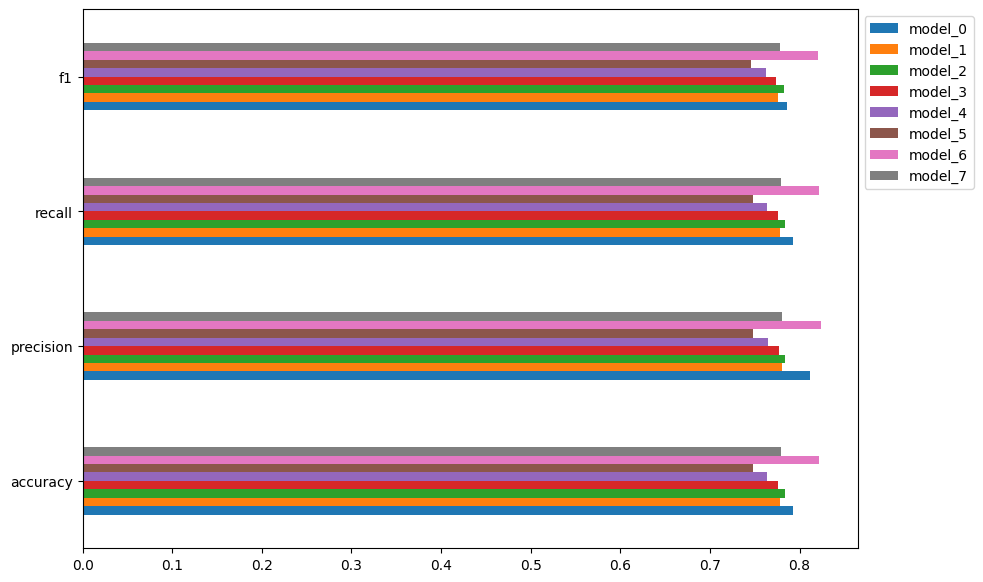

In [90]:
models_results.transpose().plot(kind="barh", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

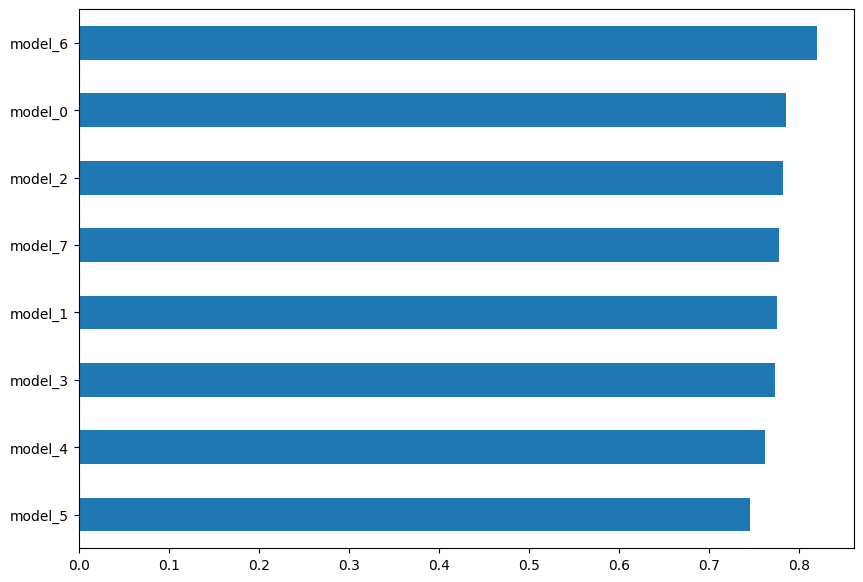

In [93]:
# Sort model results by f1-score
models_results.sort_values("f1", ascending=True)["f1"].plot(kind="barh", figsize=(10, 7))

## Saving and loading a trained model

In [94]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("savedmodels/model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [95]:
import tensorflow_hub as hub
# Load model with custom Hub Layer (required HDF5 format)
loaded_model_6_hdf5 = tf.keras.models.load_model(
    "savedmodels/model_6.h5",
    custom_objects={
        "KerasLayer": hub.KerasLayer
    }
)

In [96]:
# How does our loaded model perform?
loaded_model_6_hdf5.evaluate(val_data, val_labels)

24/24 [==============================] - 1s 4ms/step - loss: 0.4223 - accuracy: 0.8215


[0.4223065972328186, 0.8215222954750061]

In [97]:
model_6.evaluate(val_data, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4223 - accuracy: 0.8215


[0.4223065972328186, 0.8215222954750061]

In [98]:
# Save TF Hub Sentence Encoder model to Savedmodel format
model_6.save("savedmodels/model_6")

INFO:tensorflow:Assets written to: savedmodels/model_6/assets


INFO:tensorflow:Assets written to: savedmodels/model_6/assets


In [99]:
loaded_model_6_sm = tf.keras.models.load_model("savedmodels/model_6")

In [100]:
loaded_model_6_sm.evaluate(val_data, val_labels)

24/24 [==============================] - 1s 4ms/step - loss: 0.4223 - accuracy: 0.8215


[0.4223065972328186, 0.8215222954750061]

## Finding the most wrong examples

* If our model still isn't perfect, what examples is it getting wrong?
* And of these wrong example which ones is it getting most wrong?

In [101]:
!rm -rf 08_model_6_USE_feature_extractor
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip
!rm -rf 08_model_6_USE_feature_extractor.zip

--2024-11-03 14:21:15--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.210.187, 216.58.211.251, 216.58.210.155, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.210.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  30.6MB/s    in 34s     

2024-11-03 14:21:49 (27.1 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.i

In [102]:
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_data, val_labels)

24/24 [==============================] - 1s 4ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [103]:
# make predictions with the loaded model from gs
model_6_pretrained_probs = model_6_pretrained(val_data)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_probs))

In [112]:
# Create DataFrame with validation sentences and best perfroming model predictions
val_df = pd.DataFrame({
    "text": val_data,
    "target": val_labels,
    "pred": model_6_pretrained_preds,
    "prob": tf.squeeze(model_6_pretrained_probs)
})
val_df["prob"] = abs(val_df["prob"] - 0.5) * 2
val_df.head()

,text,target,pred,prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.680485
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.494324
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.977497
3,@camilacabello97 Internally and externally scr...,1,0.0,0.607541
4,Radiation emergency #preparedness starts with ...,1,1.0,0.415616


In [118]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("prob", ascending=False)
most_wrong

,text,target,pred,prob
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.925628
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.922101
38,Why are you deluged with low self-image? Take ...,1,0.0,0.922004
233,I get to smoke my shit in peace,1,0.0,0.915826
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.912163
...,...,...,...,...
659,I moved to England five years ago today. What ...,1,0.0,0.014895
335,#computers #gadgets Two giant cranes holding a...,1,0.0,0.014429
69,Back from Seattle Tacoma and Portland. Whirlwi...,1,0.0,0.009959
11,The Five Fatal Flaws in the Iran Deal https://...,0,1.0,0.008688


## Making predictions on the test dataset

In [120]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for ts in test_samples:
    probs = tf.squeeze(model_6_pretrained.predict([ts]))
    pred = tf.round(probs)
    print(f"Pred: {int(pred)}, Prob: {probs}")
    print(f"Text:\n{ts}\n")
    print("--------\n")

1/1 [==============================] - 0s 446ms/step
Pred: 0, Prob: 0.13164283335208893
Text:
*screams internally*

--------

1/1 [==============================] - 0s 32ms/step
Pred: 1, Prob: 0.7850059866905212
Text:
IF SUICIDE BOMBING WASTHE SMARTEST THING2 DO FOR ALLAH/GODJESUS/THE HOLY PROPHET MUHAMMAD COULD HAVE KILLEDSOMEBODY? http://t.co/tGfWuVVHxj

--------

1/1 [==============================] - 0s 27ms/step
Pred: 0, Prob: 0.22350972890853882
Text:
@SavanahResnik @CBS12 I would hide out at the Coldstone at monterrey and us 1. Great place to wait out a rainstorm.

--------

1/1 [==============================] - 0s 30ms/step
Pred: 1, Prob: 0.9385698437690735
Text:
'Police Officer Wounded Suspect Dead After Exchanging Shots' http://t.co/guNq7ZTUn4 #????_?????

--------

1/1 [==============================] - 0s 30ms/step
Pred: 0, Prob: 0.05317344143986702
Text:
Wrecked today got my hattrick ????

--------

1/1 [==============================] - 0s 30ms/step
Pred: 0, Prob: 0.3739

In [121]:
!rm -rf 08_model_6_USE_feature_extractor
!rm -rf savedmodels
!rm -rf helper_functions.py
!rm -rf *.csv
!rm -rf *.tsv